# Exploration of Mus Musculus aging dynamics
On the [Tabula Muris Senis](https://github.com/czbiohub/tabula-muris-senis) dataset.  
Data is raw RNA-seq counts
```
https://czb-tabula-muris-senis.s3-us-west-2.amazonaws.com/Data-objects/tabula-muris-senis-facs-official-raw-obj.h5ad
```

<!-- Gene annotations are from
```
ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Mus_musculus.gene_info.gz
``` -->

<br/>

**Pre-processed** as  
- RNA counts normalized to 1.0 per cell

<br/>

Cell **statistics** are calculated on subsets defined by a unique combination of  
- Animal sex
- Tissue type
- Subtissue type
- Cell type

<br/>

The largest found fold-changes in count between 3m and 24m age groups are reported in the table.  
**Fold-changes** are filtered as  
- Subset has >= 3 cells
- Mean count are >= 4 max(std. dev) apart
- RNA percentage is >= 1e-12 in both age groups

<br/>

### Contents
- [Part I: Exploratory analysis of a single pair of age groups on a single dataset](#Part-I:-Exploratory-analysis-of-a-single-pair-of-age-groups-on-a-single-dataset)
- [Part II: Systematic sifting through a set of age groups on both FACS and Droplet datasets](#Part-II:-Systematic-sifting-through-a-set-of-age-groups-on-both-FACS-and-Droplet-datasets)

In [144]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import gc
import numpy as np
import pandas as pd
import scanpy as sc

# Part I: Exploratory analysis of a single pair of age groups on a single dataset

In [145]:
# FACS - Raw
data = sc.read_h5ad('../data/tabula-muris/tabula-muris-senis-facs-official-raw-obj.h5ad')
# Droplet - Raw
# data = sc.read_h5ad('../data/tabula-muris/tabula-muris-senis-droplet-official-raw-obj.h5ad')

# def load_gene_info(path):
#   """Load the NCBI Gene file and returns a {gene_name: info} dictionary"""
#   gene_info = pd.read_csv(path, delimiter='\t')
#   gene_info_map = {}
#   for _, row in gene_info.iterrows():
#     info = {
#       'type': row['type_of_gene'],
#       'desc': row['Other_designations'].split('|')[0],
#     }
#     gene_info_map[row['Symbol']] = info
#     for s in row['Synonyms'].split('|'):
#       gene_info_map[s] = info
#   return gene_info, gene_info_map

# gene_info, gene_info_map = load_gene_info('../data/Mus_musculus.gene_info')
gene_names = data.var.index.values

In [146]:
data.obs.head()

,FACS.selection,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,sex,subtissue,tissue,n_genes,n_counts
index,,,,,,,,,,,,,
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,A10_B000497,bulge keratinocyte,nan,nan,facs,18_53_M,male,nan,Skin,2706,1009830.0
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,nan,pancreatic B cell,facs,18_45_M,male,Endocrine,Pancreas,3212,978772.0
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,A10_B000802,bulge keratinocyte,nan,outer bulge,facs,18_47_F,female,Skin Anagen,Skin,2243,419722.0
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,skeletal muscle satellite cell,nan,nan,facs,18_46_F,female,Muscle Diaphragm,Limb_Muscle,2789,878950.0
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,nan,B cell,facs,18_46_F,female,RV,Heart,1237,6587.0


In [147]:
# data.var[:100]
# data.obs.query('age in ["3m", "18m", "24m"]')
data.obs.groupby(['age', 'sex']).agg(['count'])
# np.sort(data.X[:2].toarray().ravel())[::-1][:1000]

FACS.selection   cell cell_ontology_class cell_ontology_id  \
                    count  count               count            count   
age sex                                                                 
3m  female          19315  19315               19315            19315   
    male            25203  25203               25203            25203   
18m female          19163  19163               19163            19163   
    male            14864  14864               14864            14864   
21m female            728    728                 728              728   
24m male            31551  31551               31551            31551   

           free_annotation method mouse.id subtissue tissue n_genes n_counts  
                     count  count    count     count  count   count    count  
age sex                                                                       
3m  female           19315  19315    19315     19315  19315   19315    19315  
    male             25203  25203    25203     25203  25203   25203    25203  
18m female           19163  19163    19163     19163  19163   19163    19163  
    male             14864  14864    14864     14864  14864   14864    14864  
21m female             728    728      728       728    728     728      728  
24m male             31551  31551    31551     31551  31551   31551    31551

## Split by age
As seen in the table above, top age for males and females is different.  
To avoid mixing the age groups, the analysis is done only for **3m** and **24m males**.

In [148]:
# Split the data by age groups that will be compared
def split_by_age(data, age_groups):
  data_by_age = {}
  for age in age_groups:
    idxs = data.obs['age'] == age
    data_by_age[age] = {
      'data': data[idxs],
      'obs': data.obs[idxs],
    }
  return data_by_age

age_groups = ['3m', '24m']
data_by_age = split_by_age(data, age_groups)

In [149]:
# We'll compute statistics for each subset defined by a unique set these cell attributes
subset_names = [
  'sex',
  'tissue',
  'subtissue',
  'cell_ontology_class',
]

In [150]:
# Preview cell-counts in the subsets
data_grouped = age_group['obs'].groupby(subset_names)
data_grouped.agg(['count']).head(20)
# data_grouped.groups

FACS.selection  \
                                                                             count   
sex  tissue        subtissue   cell_ontology_class                                   
male Aorta         Heart       aortic endothelial cell                         160   
                               epithelial cell                                  13   
                               fibroblast of cardiac tissue                     13   
                               fibrocyte                                        15   
                               macrophage                                        6   
                               professional antigen presenting cell             17   
     BAT           Fat         B cell                                          120   
                               NK cell                                           4   
                               T cell                                           44   
                               endothelial cell                                 77   
                               epithelial cell                                 111   
                               mesenchymal stem cell of adipose                101   
                               myeloid cell                                    391   
     Bladder       nan         bladder cell                                     85   
                               bladder urothelial cell                         349   
     Brain_Myeloid Cerebellum  macrophage                                      121   
                               microglial cell                                1073   
                   Cortex      macrophage                                       25   
                               microglial cell                                1034   
                   Hippocampus macrophage                                        9   

                                                                      age  \
                                                                    count   
sex  tissue        subtissue   cell_ontology_class                          
male Aorta         Heart       aortic endothelial cell                160   
                               epithelial cell                         13   
                               fibroblast of cardiac tissue            13   
                               fibrocyte                               15   
                               macrophage                               6   
                               professional antigen presenting cell    17   
     BAT           Fat         B cell                                 120   
                               NK cell                                  4   
                               T cell                                  44   
                               endothelial cell                        77   
                               epithelial cell                        111   
                               mesenchymal stem cell of adipose       101   
                               myeloid cell                           391   
     Bladder       nan         bladder cell                            85   
                               bladder urothelial cell                349   
     Brain_Myeloid Cerebellum  macrophage                             121   
                               microglial cell                       1073   
                   Cortex      macrophage                              25   
                               microglial cell                       1034   
                   Hippocampus macrophage                               9   

                                                                     cell  \
                                                                    count   
sex  tissue        subtissue   cell_ontology_class                          
male Aorta         Heart       aortic endothelial cell                160   
         

## Split into subsets
And calculate expression **mean** and **std. dev** for each one

In [151]:
def calc_subsets(age_group, subset_names):
  """Compute mean and std. dev for all the data subsets"""
  means = {}
  stds = {}
  sample_counts = {}
  i = 0
  obs_grouped = age_group['obs'].groupby(subset_names)
  for key, group in obs_grouped:
    data_array = age_group['data'][group.index].X
    # AnnData.X is usually a sparse matrix, but sometimes is an array
    if not isinstance(data_array, np.ndarray):
      data_array = data_array.toarray()
    # Skip tiny subsets
    if len(data_array.shape) < 2 or data_array.shape[0] < 3:
      continue
    data_array = data_array / (np.sum(data_array, axis=1, keepdims=True) + 1e-8)
    means[key] = np.mean(data_array, axis=0)
    stds[key] = np.std(data_array, axis=0)
    sample_counts[key] = group.index.shape[0]
    # Subsetting from AnnData can be memory-heavy, so clean it up a bit
    # (maybe, those `toarray()` calls produce the garbage?)
    if i % 10 == 0:
      gc.collect()
    i += 1
  return means, stds, sample_counts


def calc_all_subsets(data_by_age):
  means = {}
  stds = {}
  sample_counts = {}
  for age, age_group in data_by_age.items():
    means[age], stds[age], sample_counts[age] = calc_subsets(age_group, subset_names)
  return means, stds, sample_counts


means, stds, sample_counts = calc_all_subsets(data_by_age)

## Compute fold-changes in expression

In [152]:
def calc_diffs(means, stds, sample_counts, start_age, end_age):
  """Compute expression differences between age groups"""
  diffs = {}
  confidences = {}
  for key in means[start_age].keys():
    if key not in means[end_age]:
      # No corresponding subset in the other age group - skip it     
      continue
    fold_diff = np.maximum(
      means[end_age][key] / (means[start_age][key] + 1e-12),
      means[start_age][key] / (means[end_age][key] + 1e-12)
    )
  #   avg_std = (stds[start_age][key] + stds[end_age][key]) / 2.0
    diffs[key] = fold_diff
    # Ignore tiny expression amounts
    min_count = 1e-12
    diffs[key][(means[start_age][key] < min_count) | (means[end_age][key] < min_count)] = 0
    # Ignore differences less than `min_stds` std. deviations
    min_stds = 4
    abs_mean_diff = np.abs(means[end_age][key] - means[start_age][key])
    max_std = np.maximum(stds[start_age][key], stds[end_age][key])
    diffs[key][abs_mean_diff < max_std * min_stds] = 0
    
    # If sample count in both groups is >= `high_sample_count`
    # and mean difference is >= `high_stds` * max(std. dev)
    # set the measurement's confidence to 'high'
    high_sample_count = 10
    high_stds = 5
    confidences[key] = np.array(['low' for _ in np.arange(diffs[key].shape[0])], dtype=object)
    if sample_counts[start_age][key] >= high_sample_count \
      and sample_counts[end_age][key] >= high_sample_count:
      confidences[key][abs_mean_diff > max_std * high_stds] = 'high'
  return diffs, confidences


diffs, confidences = calc_diffs(means, stds, sample_counts, age_groups[0], age_groups[-1])

## Output the top `n_top` fold-changes

In [153]:
def build_results(diffs, confidences, means, stds, dataset_id, start_age, end_age, gene_names, n_top=100):
  """Sort the resulting differences and arrange 'em into a DataFrame with metadata"""
  # Python 3 dicts are ordered, be cool
  diff_arr = np.stack(list(diffs.values()), axis=0)
  confidence_arr = np.stack(list(confidences.values()), axis=0)
  subset_labels = list(diffs.keys())
  # Descending ordered indexes into _subset x gene_ expression difference array
  ordered_diff_idxs = np.unravel_index(
    np.argsort(np.abs(diff_arr), axis=None)[::-1][:n_top], 
    diff_arr.shape
  )
  gene_paths = [
    subset_labels[i] + (gene_names[j],) 
    for i, j in zip(*ordered_diff_idxs)
  ]

  # print(md_table)

  results = pd.DataFrame(
    [
      (dataset_id, start_age, end_age) \
      + path \
      + (
#         gene_info_map.get(path[-1], { 'desc': '' })['desc'],
        val,
        conf,
        means[start_age][subset_labels[idx_i]][idx_j],
        means[end_age][subset_labels[idx_i]][idx_j],
        max(
          stds[start_age][subset_labels[idx_i]][idx_j], 
          stds[end_age][subset_labels[idx_i]][idx_j]
        ),
      )
      for path, val, conf, (idx_i, idx_j) in zip(
        gene_paths, 
        diff_arr[ordered_diff_idxs], 
        confidence_arr[ordered_diff_idxs], 
        zip(*ordered_diff_idxs)
      )
    ],
    columns=[
      'Dataset', 'Start age', 'End age',
      'Sex', 'Tissue', 'Subtissue', 'Cell type', 'Gene',  # 'Gene info',
      'dExpression', 'Confidence', 
      'Expression at start age', 
      'Expression at end age', 
      'Max expression std. dev',  # '$\\Delta$Expression'
    ]
  )
  
  return results


def results2markdown(results):
  """Format DataFrame as a markdown table for in-Jupyter output"""
  # Generate Markdown table of the results
  nl = '\n'
  md_table = \
f"""
{'| ' + ' | '.join(results.columns) + ' |'}
{'| ' + ' | '.join(['---' for _ in np.arange(len(results.columns))]) + ' |'}
{nl.join([
  '| ' + ' | '.join([str(v) for v in row.values]) + ' |' 
  for _, row in results.iterrows()
])}
"""
  return md_table


results = build_results(
  diffs, confidences, means, stds, 'facs', age_groups[0], age_groups[-1], gene_names
)
md_table = results2markdown(results)
display(Markdown(md_table))


| Dataset | Start age | End age | Sex | Tissue | Subtissue | Cell type | Gene | dExpression | Confidence | Expression at start age | Expression at end age | Max expression std. dev |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Dtd1 | 6932.1611328125 | low | 0.0002861183893401176 | 4.127305430756678e-08 | 2.503326686564833e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Elavl2 | 5899.2568359375 | low | 0.0001232894865097478 | 2.0898156094517617e-08 | 2.810044497891795e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cadm3 | 3608.48583984375 | low | 7.972200546646491e-05 | 2.2091924734013446e-08 | 1.708705531200394e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sh3bgrl | 1769.1192626953125 | low | 0.00014430009468924254 | 8.156506225986959e-08 | 3.436846236581914e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Bcap29 | 1686.099609375 | low | 0.00013918265176471323 | 8.254610861513356e-08 | 3.131937774014659e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Slc9a6 | 1432.300537109375 | low | 6.328598101390526e-05 | 4.418384946802689e-08 | 8.817119123705197e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ube2j2 | 857.143798828125 | low | 3.5377797757973894e-05 | 4.127305430756678e-08 | 5.228805548540549e-06 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Zfp207 | 819.1344604492188 | low | 0.0007184036658145487 | 8.770267641011742e-07 | 0.00012388073082547635 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Acsl3 | 781.786865234375 | low | 6.453424430219457e-05 | 8.254610861513356e-08 | 8.446490937785711e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Synrg | 421.9764099121094 | low | 3.72895083273761e-05 | 8.836769893605378e-08 | 3.0040857836866053e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Jkamp | 399.6438903808594 | low | 0.00033710073330439627 | 8.435017662122846e-07 | 6.400504935299978e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Exosc4 | 349.74554443359375 | low | 0.00015662955411244184 | 4.4783760699829145e-07 | 3.3703377994243056e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Smap1 | 254.5473175048828 | low | 5.999808126944117e-05 | 2.3570402163386461e-07 | 1.4144125088932924e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Atox1 | 247.58750915527344 | low | 4.23685232817661e-05 | 1.7112445505063079e-07 | 4.495492703426862e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Stoml1 | 234.46282958984375 | low | 0.00011126169556519017 | 4.74537756645077e-07 | 1.480811715737218e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cd47 | 187.16139221191406 | low | 0.00019630230963230133 | 1.0488387260920717e-06 | 3.7241916288621724e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Atcay | 180.71629333496094 | low | 8.575688116252422e-05 | 4.74537756645077e-07 | 1.9027294911211357e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Pdcd10 | 164.47967529296875 | low | 3.394305895199068e-05 | 2.0636528574868862e-07 | 7.092454325174913e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fhl1 | 155.46849060058594 | low | 0.000115500035462901 | 7.429150059579115e-07 | 2.709986256377306e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Lpcat4 | 126.99359893798828 | low | 3.669002398964949e-05 | 2.889113943638222e-07 | 2.592678811197402e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fbxo25 | 123.82343292236328 | low | 4.380326208774932e-05 | 3.537548423082626e-07 | 6.652513093285961e-06 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Maged1 | 123.55155944824219 | low | 0.0008434218470938504 | 6.826475782872876e-06 | 1.6721382053219713e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Hars | 117.12635040283203 | low | 0.00018573288980405778 | 1.5857470998525969e-06 | 2.393080467300024e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Actr3b | 113.75975799560547 | low | 3.2866602850845084e-05 | 2.889113943638222e-07 | 3.0874766707711387e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Aamp | 113.1150131225586 | low | 0.00019391172099858522 | 1.714287122922542e-06 | 2.8786345865228213e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Vps35 | 110.80747985839844 | low | 0.00010731767542893067 | 9.68504650700197e-07 | 1.8777749573928304e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zc3h15 | 108.31239318847656 | low | 0.000287061178823933 | 2.6503068966121646e-06 | 5.461356704472564e-05 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Tff3 | 107.42471313476562 | low | 3.53552735532503e-07 | 3.7980407796567306e-05 | 5.67590768696391e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | D4Wsu53e | 103.3076400756836 | low | 0.0001601385447429493 | 1.5501123016292695e-06 | 3.3095617254730314e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Psma5 | 94.46321105957031 | low | 0.00022042711498215795 | 2.333469637960661e-06 | 4.299937063478865e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Vapb | 91.9941177368164 | low | 9.223807137459517e-05 | 1.0026508334703976e-06 | 5.5150849220808595e-06 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Foxc1 | 86.31624603271484 | low | 0.00015140340838115662 | 1.7540535282023484e-06 | 3.179585837642662e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | BC018242 | 86.1949691772461 | low | 5.455343853100203e-05 | 6.329064490273595e-07 | 1.2181661077192985e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rbbp4 | 83.33859252929688 | low | 0.00010045297676697373 | 1.2053586715410347e-06 | 1.1883541446877643e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Epm2aip1 | 77.09756469726562 | low | 8.84325199876912e-05 | 1.1470199297036743e-06 | 2.0600064090103842e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fzr1 | 75.0069580078125 | low | 0.00021051219664514065 | 2.8065678634447977e-06 | 3.9667924284003675e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rnps1 | 69.85926818847656 | low | 7.039731281111017e-05 | 1.0077008028019918e-06 | 1.58505226863781e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Plcxd2 | 68.34178161621094 | low | 0.00013660397962667048 | 1.998834704863839e-06 | 2.532440521463286e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Rab11b | 67.75608825683594 | low | 0.0005348151898942888 | 7.89324076322373e-06 | 7.26166763342917e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Bcap31 | 65.34976196289062 | low | 0.00019892677664756775 | 3.044031245735823e-06 | 2.95964528049808e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rps6kb1 | 65.1226577758789 | low | 8.987268665805459e-05 | 1.380051457999798e-06 | 1.8104847185895778e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mllt11 | 62.763797760009766 | low | 0.0004819491587113589 | 7.678775546082761e-06 | 5.713577047572471e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Slk | 60.38515090942383 | low | 4.505885954131372e-05 | 7.461900395355769e-07 | 7.770414413243998e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zcrb1 | 58.58479309082031 | low | 7.66698649385944e-05 | 1.3086980743537424e-06 | 9.61711339186877e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zc3hc1 | 58.46612548828125 | low | 0.00011341460049152374 | 1.9398335098230746e-06 | 2.3227768906508572e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ncs1 | 55.50006866455078 | low | 7.630424079252407e-05 | 1.3748484661846305e-06 | 1.815832729334943e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sdf2 | 55.01450729370117 | low | 3.89014785469044e-05 | 7.071120649015938e-07 | 2.9841514788131462e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ccdc104 | 49.31513595581055 | low | 0.00015775146312080324 | 3.198843842255883e-06 | 3.647322591859847e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Eif5 | 47.979610443115234 | low | 0.00039523420855402946 | 8.2375445344951e-06 | 4.662505307351239e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cldn25 | 45.707435607910156 | low | 6.506975478259847e-05 | 1.4236131846701028e-06 | 1.5873707525315695e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Dcaf7 | 45.06200408935547 | low | 5.516026067198254e-05 | 1.2240958540132851e-06 | 1.1635886039584875e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Setd5 | 44.08477020263672 | low | 9.197279723593965e-05 | 2.0862705696345074e-06 | 2.210630918852985e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Usp14 | 42.06341552734375 | low | 0.00015238739433698356 | 3.6228002500138246e-06 | 3.140374246868305e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Abr | 41.60276794433594 | low | 0.00024039031995926052 | 5.778228114650119e-06 | 5.72172793908976e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Eif4g1 | 38.829566955566406 | low | 0.0001983893453143537 | 5.109233370603761e-06 | 2.0219038560753688e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mapk8 | 38.664310455322266 | low | 1.159277144324733e-05 | 2.9983033300595707e-07 | 7.726307558186818e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fam63b | 38.002689361572266 | low | 0.00011700607865350321 | 3.0788885396759724e-06 | 1.613821768842172e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Nfic | 34.21809387207031 | low | 0.00017187208868563175 | 5.022841378377052e-06 | 3.569317777873948e-05 |
| facs | 3m | 24m | male | Marrow | KLS | naive B cell | Hnrnpc | 32.247623443603516 | low | 0.0008602550369687378 | 2.6676540073822252e-05 | 8.745181548874825e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Habp4 | 29.995569229125977 | low | 0.00013014684373047203 | 4.338868166087195e-06 | 1.835448529163841e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rab2a | 29.241680145263672 | low | 0.00057167187333107 | 1.9549896023818292e-05 | 6.986805965425447e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mmgt1 | 29.147235870361328 | low | 6.339923857012764e-05 | 2.1751363874500385e-06 | 1.0355677659390494e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | H2afy | 27.559703826904297 | low | 0.00019749936473090202 | 7.16623617336154e-06 | 2.606572707009036e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Tra2b | 25.839624404907227 | low | 0.0002655244607012719 | 1.0275863132847007e-05 | 1.429634812666336e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | 2810428I15Rik | 25.670124053955078 | low | 0.00013513297017198056 | 5.264210813038517e-06 | 2.0130402845097706e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Gdi1 | 25.06322479248047 | low | 0.00039324606768786907 | 1.5690160580561496e-05 | 7.865211955504492e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rsrc1 | 24.928234100341797 | low | 4.583557529258542e-05 | 1.8387002000963548e-06 | 7.1268091232923325e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Gng10 | 24.431503295898438 | low | 3.0480845452984795e-05 | 0.0007446929230354726 | 0.0001043185475282371 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Son | 24.259098052978516 | low | 0.00012644995877053589 | 5.212474661675515e-06 | 2.397339449089486e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ypel5 | 23.63601303100586 | low | 0.00020580423006322235 | 8.707230335858185e-06 | 3.0360990422195755e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | 1810022K09Rik | 22.63136863708496 | low | 8.574952516937628e-05 | 3.788966751017142e-06 | 1.5443056327058002e-05 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Hist1h2ab | 22.621097564697266 | low | 0.00045099385897628963 | 1.9936867829528637e-05 | 6.776619557058439e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Anp32b | 22.53068733215332 | low | 3.615450987126678e-05 | 1.6046774362621363e-06 | 8.607833478890825e-06 |
| facs | 3m | 24m | male | BAT | Fat | NK cell | Whsc1l1 | 22.440885543823242 | low | 2.6982015697285533e-05 | 0.0006055003614164889 | 5.147761112311855e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rplp0 | 21.424551010131836 | low | 0.00018459053535480052 | 8.615840670245234e-06 | 3.552401176420972e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Prdx3 | 20.350372314453125 | low | 0.0003212607989553362 | 1.578648152644746e-05 | 4.628938768291846e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rraga | 19.075664520263672 | low | 0.00028236789512448013 | 1.4802518307988066e-05 | 5.714257713407278e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rac1 | 18.258609771728516 | low | 0.00019959022756665945 | 1.0931293218163773e-05 | 2.695038892852608e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Hspe1 | 17.514415740966797 | low | 0.00019953709852416068 | 1.1392734450055286e-05 | 4.187239392194897e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Uchl5 | 17.107982635498047 | low | 5.772074291598983e-05 | 3.3739061109372415e-06 | 1.2459564459277317e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mapkap1 | 16.45646858215332 | low | 9.082312317332253e-05 | 5.518991656572325e-06 | 1.9201115719624795e-05 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Dhx15 | 16.12666893005371 | low | 0.00019692567002493888 | 1.2211180546728428e-05 | 3.384032970643602e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Gpm6a | 15.66448974609375 | low | 0.00045810718438588083 | 2.9244945835671388e-05 | 8.480664109811187e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | C1qbp | 15.44394302368164 | low | 0.00017608178313821554 | 1.1401348274375778e-05 | 2.792748637148179e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ociad1 | 15.245709419250488 | low | 0.0006245953845791519 | 4.0968599932966754e-05 | 0.00011696721048792824 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sqstm1 | 14.898940086364746 | low | 0.0005039646057412028 | 3.382553404662758e-05 | 7.173463382059708e-05 |
| facs | 3m | 24m | male | Heart | RV | atrial myocyte | Egr1 | 13.928227424621582 | low | 0.001849191845394671 | 0.00013276576646603644 | 0.0002950190391857177 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Blmh | 12.584068298339844 | low | 0.0004304260655771941 | 3.420404755161144e-05 | 8.378246275242418e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ywhaz | 10.178587913513184 | low | 0.0007347743376158178 | 7.218823884613812e-05 | 0.00016123020031955093 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Abhd16a | 10.097661018371582 | low | 6.186101381899789e-05 | 0.0006246515549719334 | 0.00012336914369370788 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Gadd45gip1 | 9.94238567352295 | low | 3.4373588277958333e-05 | 0.00034175548353232443 | 6.071141251595691e-05 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Tmsb10 | 8.794313430786133 | low | 9.355727524962276e-05 | 0.0008227719808928668 | 0.00014500287943519652 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Fermt2 | 8.409576416015625 | low | 0.0002789145801216364 | 3.316630682093091e-05 | 5.083139330963604e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Atp5j2 | 7.897420883178711 | low | 0.00019170991436112672 | 2.42750011238968e-05 | 3.589597690734081e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Swi5 | 7.240354061126709 | low | 0.00014326264499686658 | 0.0010372722754254937 | 0.0001825126091716811 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Agtpbp1 | 7.028994560241699 | low | 5.850868546986021e-05 | 0.00041125723510049284 | 8.153079397743568e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Rock1 | 5.709273338317871 | low | 0.0008379295468330383 | 0.00014676641148980707 | 0.00017150095663964748 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Lgals3 | 5.34489631652832 | low | 0.0003578383184503764 | 0.0019126086262986064 | 0.00034995749592781067 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Rpsa | 5.111270904541016 | low | 0.0013487390242516994 | 0.006893770303577185 | 0.0013369768857955933 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Cfl1 | 4.983508586883545 | low | 0.0009635951137170196 | 0.004802084527909756 | 0.0009180501801893115 |


# Part II: Systematic sifting through a set of age groups on both FACS and Droplet datasets

In [154]:
datasets = [
  {
    'id': 'facs',
    'path': '../data/tabula-muris/tabula-muris-senis-facs-official-raw-obj.h5ad',
    'age_groups': [ ('3m', '18m'), ('3m', '24m'), ('18m', '24m') ],
  },
  {
    'id': 'droplet',
    'path': '../data/tabula-muris/tabula-muris-senis-droplet-official-raw-obj.h5ad',
    'age_groups': [
      ('3m', '18m'), ('3m', '21m'), ('3m', '24m'), ('18m', '21m'), 
    ],
  },
]

all_results = {}
for dataset in datasets:
  data = sc.read_h5ad(dataset['path'])
  gene_names = data.var.index.values
  for age_groups in dataset['age_groups']:
    data_by_age = split_by_age(data, age_groups)
    subset_names = [
      'sex',
      'tissue',
      'subtissue',
      'cell_ontology_class',
    ]
    # Get RNA count stats for all cell subsets defined by `subset_names`
    means, stds, sample_counts = calc_all_subsets(data_by_age)
    # Compute differences in mean expressions between age groups
    diffs, confidences = calc_diffs(means, stds, sample_counts, age_groups[0], age_groups[-1])
    if len(diffs) < 1:
      print(
        'age groups {0} in {1} dataset have no intersecting cell subsets, no differences were computed' \
        .format(age_groups, dataset['id'])
      )
      continue
    results = build_results(
      diffs, confidences, means, stds, dataset['id'], age_groups[0], age_groups[-1], gene_names
    )
    results.to_csv(
      './results/{0}-{1}-{2}.csv'.format(
        dataset['id'], age_groups[0], age_groups[-1]
      )
    )
    all_results[(dataset['id'], age_groups[0], age_groups[-1])] = results

In [159]:
merged_results = pd.concat(all_results.values()) \
  .sort_values(['dExpression'], ascending=[False])
merged_results = merged_results[merged_results['dExpression'] > 2.0]
# merged_results.head(100)
# merged_grouped_results = merged_results.groupby([
#   'Sex', 'Tissue', 'Subtissue', 'Cell type', 'Gene'
# ])
# merged_grouped_results.head()

merged_results.to_csv('./results/merged.csv')

md_table = results2markdown(merged_results)
display(Markdown(md_table))


| Dataset | Start age | End age | Sex | Tissue | Subtissue | Cell type | Gene | dExpression | Confidence | Expression at start age | Expression at end age | Max expression std. dev |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Dtd1 | 6932.1611328125 | low | 0.0002861183893401176 | 4.127305430756678e-08 | 2.503326686564833e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Elavl2 | 5899.2568359375 | low | 0.0001232894865097478 | 2.0898156094517617e-08 | 2.810044497891795e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cadm3 | 3608.48583984375 | low | 7.972200546646491e-05 | 2.2091924734013446e-08 | 1.708705531200394e-05 |
| facs | 18m | 24m | male | Pancreas | Exocrine | leukocyte | Dpm1 | 3133.759765625 | low | 7.14652196620591e-05 | 2.2803945398663927e-08 | 1.7566524547873996e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sh3bgrl | 1769.1192626953125 | low | 0.00014430009468924254 | 8.156506225986959e-08 | 3.436846236581914e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Bcap29 | 1686.099609375 | low | 0.00013918265176471323 | 8.254610861513356e-08 | 3.131937774014659e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Slc9a6 | 1432.300537109375 | low | 6.328598101390526e-05 | 4.418384946802689e-08 | 8.817119123705197e-06 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Pdlim1 | 1105.71142578125 | low | 0.00017111162014771253 | 1.547515182664938e-07 | 3.738513623829931e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Ptpra | 986.6050415039062 | low | 0.0001526796113466844 | 1.547515182664938e-07 | 3.377893517608754e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Cd27 | 899.2661743164062 | low | 0.0002411329187452793 | 2.681431112705468e-07 | 2.3775452064001e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ube2j2 | 857.143798828125 | low | 3.5377797757973894e-05 | 4.127305430756678e-08 | 5.228805548540549e-06 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Clns1a | 822.1781005859375 | low | 0.00022046221420168877 | 2.681431112705468e-07 | 5.081414565211162e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Zfp207 | 819.1344604492188 | low | 0.0007184036658145487 | 8.770267641011742e-07 | 0.00012388073082547635 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Acsl3 | 781.786865234375 | low | 6.453424430219457e-05 | 8.254610861513356e-08 | 8.446490937785711e-06 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Hsd3b7 | 752.0015258789062 | low | 0.0002016447833739221 | 2.681431112705468e-07 | 3.1053928069013637e-06 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Tacstd2 | 460.68017578125 | low | 0.00012352867634035647 | 2.681431112705468e-07 | 5.152310677658534e-06 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Dnajc2 | 455.53509521484375 | low | 0.0001221490529133007 | 2.681431112705468e-07 | 8.840168447932228e-06 |
| facs | 3m | 18m | female | Lung | EPCAM | club cell of bronchiole | Cd47 | 444.84893798828125 | low | 9.72716293290432e-07 | 0.0004327122587710619 | 6.310861499514431e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Synrg | 421.9764099121094 | low | 3.72895083273761e-05 | 8.836769893605378e-08 | 3.0040857836866053e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Jkamp | 399.6438903808594 | low | 0.00033710073330439627 | 8.435017662122846e-07 | 6.400504935299978e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Diap1 | 359.659912109375 | low | 2.1613135459119803e-07 | 7.773414108669385e-05 | 1.5771256585139781e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Exosc4 | 349.74554443359375 | low | 0.00015662955411244184 | 4.4783760699829145e-07 | 3.3703377994243056e-05 |
| facs | 3m | 18m | female | BAT | Fat | mesenchymal stem cell of adipose | Dok1 | 327.2217102050781 | low | 1.324565118920873e-06 | 0.00043342678691260517 | 2.572993435023818e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Smap1 | 254.5473175048828 | low | 5.999808126944117e-05 | 2.3570402163386461e-07 | 1.4144125088932924e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Atox1 | 247.58750915527344 | low | 4.23685232817661e-05 | 1.7112445505063079e-07 | 4.495492703426862e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Stoml1 | 234.46282958984375 | low | 0.00011126169556519017 | 4.74537756645077e-07 | 1.480811715737218e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Shmt2 | 213.06256103515625 | low | 0.00021431663481052965 | 1.0058848829430644e-06 | 3.7119501939741895e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cd47 | 187.16139221191406 | low | 0.00019630230963230133 | 1.0488387260920717e-06 | 3.7241916288621724e-05 |
| facs | 3m | 18m | female | Marrow | Granulocytes | granulocyte monocyte progenitor cell | 1110057K04Rik | 187.08572387695312 | low | 3.1943451972438197e-07 | 5.976182364975102e-05 | 1.1634917427727487e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Atcay | 180.71629333496094 | low | 8.575688116252422e-05 | 4.74537756645077e-07 | 1.9027294911211357e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Rbm7 | 180.29808044433594 | low | 4.834586798097007e-05 | 2.681431112705468e-07 | 5.443544068839401e-06 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Casp8 | 168.73402404785156 | low | 9.629671922084526e-07 | 0.00016248550673481077 | 1.0254399967379868e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Pdcd10 | 164.47967529296875 | low | 3.394305895199068e-05 | 2.0636528574868862e-07 | 7.092454325174913e-06 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | 1110057K04Rik | 161.76339721679688 | low | 4.337590144132264e-05 | 2.681431112705468e-07 | 1.0274943633703515e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Casp8 | 161.53472900390625 | low | 0.00016248550673481077 | 1.0058848829430644e-06 | 1.0254399967379868e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fhl1 | 155.46849060058594 | low | 0.000115500035462901 | 7.429150059579115e-07 | 2.709986256377306e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Copb1 | 143.7480926513672 | low | 6.570920731974184e-07 | 9.445587784284726e-05 | 1.0233995453745592e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Snapc2 | 139.1177520751953 | low | 5.38218482688535e-05 | 3.868788098770892e-07 | 1.0855776963580865e-05 |
| facs | 3m | 18m | female | BAT | Fat | mesenchymal stem cell of adipose | Atp8b2 | 130.95584106445312 | low | 1.405154648637108e-06 | 0.00018401334818918258 | 1.3596402823168319e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Lpcat4 | 126.99359893798828 | low | 3.669002398964949e-05 | 2.889113943638222e-07 | 2.592678811197402e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fbxo25 | 123.82343292236328 | low | 4.380326208774932e-05 | 3.537548423082626e-07 | 6.652513093285961e-06 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Maged1 | 123.55155944824219 | low | 0.0008434218470938504 | 6.826475782872876e-06 | 1.6721382053219713e-05 |
| facs | 3m | 18m | male | Heart | RV | atrial myocyte | Slc25a39 | 119.8050765991211 | low | 3.090981408604421e-05 | 0.003703152760863304 | 0.0006730743916705251 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Hars | 117.12635040283203 | low | 0.00018573288980405778 | 1.5857470998525969e-06 | 2.393080467300024e-05 |
| facs | 18m | 24m | male | Heart | RV | atrial myocyte | Snca | 116.47969055175781 | low | 0.011833259835839272 | 0.00010159075463889167 | 0.00143025116994977 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Atxn1 | 115.3592529296875 | low | 1.4118841136223637e-06 | 0.0001628740137675777 | 3.1902258342597634e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Actr3b | 113.75975799560547 | low | 3.2866602850845084e-05 | 2.889113943638222e-07 | 3.0874766707711387e-06 |
| facs | 3m | 18m | female | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Mgea5 | 113.32071685791016 | low | 6.388690394487639e-07 | 7.239721162477508e-05 | 1.095508378057275e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Aamp | 113.1150131225586 | low | 0.00019391172099858522 | 1.714287122922542e-06 | 2.8786345865228213e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Agpat5 | 111.73849487304688 | low | 3.4583514207042754e-05 | 3.095030365329876e-07 | 8.048769814195111e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Vps35 | 110.80747985839844 | low | 0.00010731767542893067 | 9.68504650700197e-07 | 1.8777749573928304e-05 |
| facs | 3m | 18m | male | Pancreas | Exocrine | leukocyte | Nt5c | 109.74200439453125 | low | 8.285974786303996e-07 | 9.093205881072208e-05 | 1.945535041159019e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Enpp5 | 108.83572387695312 | low | 4.814835961042263e-07 | 5.240272730588913e-05 | 9.732999387779273e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zc3h15 | 108.31239318847656 | low | 0.000287061178823933 | 2.6503068966121646e-06 | 5.461356704472564e-05 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Tff3 | 107.42471313476562 | low | 3.53552735532503e-07 | 3.7980407796567306e-05 | 5.67590768696391e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | D4Wsu53e | 103.3076400756836 | low | 0.0001601385447429493 | 1.5501123016292695e-06 | 3.3095617254730314e-05 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | BC005561 | 100.93986511230469 | low | 9.0335204731673e-05 | 8.949397738433618e-07 | 1.8180351617047563e-05 |
| facs | 18m | 24m | male | Pancreas | Exocrine | pancreatic B cell | Tab2 | 97.77722930908203 | low | 3.28491696564015e-05 | 3.359583047313208e-07 | 7.2099755925592035e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Psma5 | 94.46321105957031 | low | 0.00022042711498215795 | 2.333469637960661e-06 | 4.299937063478865e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Vapb | 91.9941177368164 | low | 9.223807137459517e-05 | 1.0026508334703976e-06 | 5.5150849220808595e-06 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | 1700019E19Rik | 86.35850524902344 | low | 5.794840944872703e-07 | 5.00434689456597e-05 | 8.4327884906088e-06 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Foxc1 | 86.31624603271484 | low | 0.00015140340838115662 | 1.7540535282023484e-06 | 3.179585837642662e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | BC018242 | 86.1949691772461 | low | 5.455343853100203e-05 | 6.329064490273595e-07 | 1.2181661077192985e-05 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Nudt16 | 83.50288391113281 | low | 2.993628868352971e-06 | 0.00024997672880999744 | 2.50270441028988e-05 |
| droplet | 3m | 18m | female | Lung | nan | dendritic cell | Hist1h2ae | 83.43202209472656 | low | 8.570082172809634e-06 | 0.0007150193559937179 | 4.4753673137165606e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rbbp4 | 83.33859252929688 | low | 0.00010045297676697373 | 1.2053586715410347e-06 | 1.1883541446877643e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Epm2aip1 | 77.09756469726562 | low | 8.84325199876912e-05 | 1.1470199297036743e-06 | 2.0600064090103842e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fzr1 | 75.0069580078125 | low | 0.00021051219664514065 | 2.8065678634447977e-06 | 3.9667924284003675e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Cct6a | 69.87955474853516 | low | 0.000281163229374215 | 4.023539531772258e-06 | 3.956514046876691e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rnps1 | 69.85926818847656 | low | 7.039731281111017e-05 | 1.0077008028019918e-06 | 1.58505226863781e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Plcxd2 | 68.34178161621094 | low | 0.00013660397962667048 | 1.998834704863839e-06 | 2.532440521463286e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Rab11b | 67.75608825683594 | low | 0.0005348151898942888 | 7.89324076322373e-06 | 7.26166763342917e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Fkbp3 | 67.63428497314453 | low | 0.00012559816241264343 | 1.8570182191979256e-06 | 3.0340323064592667e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Bcap31 | 65.34976196289062 | low | 0.00019892677664756775 | 3.044031245735823e-06 | 2.95964528049808e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rps6kb1 | 65.1226577758789 | low | 8.987268665805459e-05 | 1.380051457999798e-06 | 1.8104847185895778e-05 |
| droplet | 18m | 21m | female | Lung | nan | basophil | Dtx3 | 63.95588684082031 | low | 0.00026497917133383453 | 4.14315445596003e-06 | 5.7270364777650684e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mllt11 | 62.763797760009766 | low | 0.0004819491587113589 | 7.678775546082761e-06 | 5.713577047572471e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Slk | 60.38515090942383 | low | 4.505885954131372e-05 | 7.461900395355769e-07 | 7.770414413243998e-06 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Txndc17 | 58.97379684448242 | low | 1.2490506833273685e-06 | 7.366132194874808e-05 | 1.320849059993634e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zcrb1 | 58.58479309082031 | low | 7.66698649385944e-05 | 1.3086980743537424e-06 | 9.61711339186877e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zc3hc1 | 58.46612548828125 | low | 0.00011341460049152374 | 1.9398335098230746e-06 | 2.3227768906508572e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | 2810002N01Rik | 57.751792907714844 | low | 3.0971550586400554e-05 | 5.362862225410936e-07 | 3.4481461170798866e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ncs1 | 55.50006866455078 | low | 7.630424079252407e-05 | 1.3748484661846305e-06 | 1.815832729334943e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sdf2 | 55.01450729370117 | low | 3.89014785469044e-05 | 7.071120649015938e-07 | 2.9841514788131462e-06 |
| facs | 3m | 18m | male | Heart | RV | atrial myocyte | Bnip3l | 50.65662384033203 | low | 9.910017251968384e-05 | 0.005020080134272575 | 0.001106241368688643 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Actr1a | 49.791927337646484 | low | 7.884711521910504e-05 | 1.5835311160117271e-06 | 1.2354802493064199e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ccdc104 | 49.31513595581055 | low | 0.00015775146312080324 | 3.198843842255883e-06 | 3.647322591859847e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Eif5 | 47.979610443115234 | low | 0.00039523420855402946 | 8.2375445344951e-06 | 4.662505307351239e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Actl6a | 47.43008041381836 | low | 0.00012844789307564497 | 2.7081516691396246e-06 | 2.4507666239514947e-05 |
| facs | 3m | 18m | male | Pancreas | Exocrine | leukocyte | Gtf2f1 | 45.85951614379883 | low | 4.85155806018156e-06 | 0.00022249015455599874 | 3.3243348298128694e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cldn25 | 45.707435607910156 | low | 6.506975478259847e-05 | 1.4236131846701028e-06 | 1.5873707525315695e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Dcaf7 | 45.06200408935547 | low | 5.516026067198254e-05 | 1.2240958540132851e-06 | 1.1635886039584875e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Setd5 | 44.08477020263672 | low | 9.197279723593965e-05 | 2.0862705696345074e-06 | 2.210630918852985e-05 |
| droplet | 18m | 21m | female | Lung | nan | dendritic cell | Hist1h2ae | 43.59051513671875 | low | 0.0007150193559937179 | 1.6403093468397856e-05 | 4.4753673137165606e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Usp14 | 42.06341552734375 | low | 0.00015238739433698356 | 3.6228002500138246e-06 | 3.140374246868305e-05 |
| facs | 18m | 24m | male | Pancreas | Exocrine | leukocyte | Acsl5 | 41.797035217285156 | low | 0.00017932080663740635 | 4.2902747736661695e-06 | 4.028751573059708e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Abr | 41.60276794433594 | low | 0.00024039031995926052 | 5.778228114650119e-06 | 5.72172793908976e-05 |
| droplet | 18m | 21m | female | Lung | nan | basophil | Atp8b5 | 41.17457580566406 | low | 0.00026497917133383453 | 6.435503564716782e-06 | 5.7270364777650684e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Eif4g1 | 38.829566955566406 | low | 0.0001983893453143537 | 5.109233370603761e-06 | 2.0219038560753688e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mapk8 | 38.664310455322266 | low | 1.159277144324733e-05 | 2.9983033300595707e-07 | 7.726307558186818e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fam63b | 38.002689361572266 | low | 0.00011700607865350321 | 3.0788885396759724e-06 | 1.613821768842172e-05 |
| facs | 3m | 18m | male | Heart | RV | atrial myocyte | Sri | 37.67798614501953 | low | 0.0007981992675922811 | 2.1184761862969026e-05 | 6.453680543927476e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Tm2d2 | 37.56961441040039 | low | 0.00019803711620625108 | 5.271203463053098e-06 | 4.433418143889867e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Iqgap2 | 36.426963806152344 | low | 4.579852429742459e-06 | 0.00016683015564922243 | 2.1049130737083033e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Nfic | 34.21809387207031 | low | 0.00017187208868563175 | 5.022841378377052e-06 | 3.569317777873948e-05 |
| facs | 3m | 18m | male | Heart | RV | atrial myocyte | Malat1 | 33.72757339477539 | low | 0.007973603904247284 | 0.000236412015510723 | 0.0012658793712034822 |
| facs | 3m | 18m | male | Heart | RV | atrial myocyte | Fau | 33.29037094116211 | low | 0.00016137491911649704 | 4.8474944378540386e-06 | 3.250987356295809e-05 |
| facs | 3m | 24m | male | Marrow | KLS | naive B cell | Hnrnpc | 32.247623443603516 | low | 0.0008602550369687378 | 2.6676540073822252e-05 | 8.745181548874825e-05 |
| facs | 3m | 18m | female | Heart | RA | valve cell | Il2ra | 30.95924949645996 | low | 6.392658542608842e-05 | 2.064861291728448e-06 | 1.4041180293133948e-05 |
| droplet | 3m | 18m | male | Kidney | nan | brush cell | Rpl22l1 | 30.25253677368164 | low | 0.0005986650357954204 | 1.978891850740183e-05 | 0.00012213228910695761 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Habp4 | 29.995569229125977 | low | 0.00013014684373047203 | 4.338868166087195e-06 | 1.835448529163841e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Ctage5 | 29.85346031188965 | low | 3.46490451192949e-05 | 1.1606364296312677e-06 | 2.0102813778066775e-06 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Sfxn1 | 29.259685516357422 | low | 4.2317733459640294e-06 | 0.0001238203840330243 | 2.325719833606854e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rab2a | 29.241680145263672 | low | 0.00057167187333107 | 1.9549896023818292e-05 | 6.986805965425447e-05 |
| droplet | 18m | 21m | female | Pancreas | Endocrine | pancreatic ductal cel | Try4 | 29.233570098876953 | low | 1.0632415978761856e-05 | 0.000310823495965451 | 4.886306487605907e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mmgt1 | 29.147235870361328 | low | 6.339923857012764e-05 | 2.1751363874500385e-06 | 1.0355677659390494e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | H2afy | 27.559703826904297 | low | 0.00019749936473090202 | 7.16623617336154e-06 | 2.606572707009036e-05 |
| facs | 3m | 18m | male | Pancreas | Exocrine | leukocyte | Med11 | 27.450279235839844 | low | 3.416789695620537e-06 | 9.379185939906165e-05 | 1.075742329703644e-05 |
| facs | 18m | 24m | male | SCAT | Fat | T cell | Ddx50 | 26.02545928955078 | low | 0.000272726989351213 | 1.0479237062099855e-05 | 5.159190186532214e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Tra2b | 25.839624404907227 | low | 0.0002655244607012719 | 1.0275863132847007e-05 | 1.429634812666336e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | 2810428I15Rik | 25.670124053955078 | low | 0.00013513297017198056 | 5.264210813038517e-06 | 2.0130402845097706e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Krt18 | 25.314891815185547 | low | 0.0001334399712504819 | 5.271203463053098e-06 | 1.6247699022642337e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Gdi1 | 25.06322479248047 | low | 0.00039324606768786907 | 1.5690160580561496e-05 | 7.865211955504492e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rsrc1 | 24.928234100341797 | low | 4.583557529258542e-05 | 1.8387002000963548e-06 | 7.1268091232923325e-06 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Pon2 | 24.82545280456543 | low | 0.00013929617125540972 | 5.611021606455324e-06 | 3.0923391022952273e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Tnfrsf18 | 24.64614486694336 | low | 6.495744310086593e-05 | 2.635601731526549e-06 | 7.474723588529741e-06 |
| facs | 18m | 24m | male | Lung | EPCAM | T cell | Vapa | 24.486080169677734 | low | 0.0006172675057314336 | 2.5208912120433524e-05 | 0.00012815542868338525 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Gng10 | 24.431503295898438 | low | 3.0480845452984795e-05 | 0.0007446929230354726 | 0.0001043185475282371 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Son | 24.259098052978516 | low | 0.00012644995877053589 | 5.212474661675515e-06 | 2.397339449089486e-05 |
| facs | 3m | 18m | female | Lung | EPCAM | club cell of bronchiole | Aes | 23.650203704833984 | low | 3.404506787774153e-05 | 0.0008051727782003582 | 0.00015315230120904744 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ypel5 | 23.63601303100586 | low | 0.00020580423006322235 | 8.707230335858185e-06 | 3.0360990422195755e-05 |
| droplet | 18m | 21m | female | Lung | nan | plasma cell | Pdpk1 | 23.167682647705078 | low | 9.430640056962147e-05 | 4.070600425620796e-06 | 1.5765370335429907e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | 1810022K09Rik | 22.63136863708496 | low | 8.574952516937628e-05 | 3.788966751017142e-06 | 1.5443056327058002e-05 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Hist1h2ab | 22.621097564697266 | low | 0.00045099385897628963 | 1.9936867829528637e-05 | 6.776619557058439e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Anp32b | 22.53068733215332 | low | 3.615450987126678e-05 | 1.6046774362621363e-06 | 8.607833478890825e-06 |
| facs | 3m | 24m | male | BAT | Fat | NK cell | Whsc1l1 | 22.440885543823242 | low | 2.6982015697285533e-05 | 0.0006055003614164889 | 5.147761112311855e-05 |
| droplet | 18m | 21m | female | Lung | nan | dendritic cell | Suz12 | 22.33538818359375 | low | 0.00012152735871495679 | 5.441022040031385e-06 | 1.538953438284807e-05 |
| facs | 18m | 24m | male | Heart | RV | atrial myocyte | Alas2 | 21.94597625732422 | low | 0.053562868386507034 | 0.002440669108182192 | 0.010063135996460915 |
| facs | 3m | 18m | female | Lung | EPCAM | club cell of bronchiole | Sftpb | 21.429615020751953 | low | 0.00017950497567653656 | 0.003846722422167659 | 0.00068414252018556 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rplp0 | 21.424551010131836 | low | 0.00018459053535480052 | 8.615840670245234e-06 | 3.552401176420972e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Cln6 | 21.32185173034668 | low | 0.00011239184095757082 | 5.271203463053098e-06 | 2.1062945961602964e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Dcun1d1 | 21.308225631713867 | low | 0.00012570040416903794 | 5.899148163734935e-06 | 2.9196555260568857e-05 |
| droplet | 18m | 21m | female | Lung | nan | plasma cell | Sms | 21.26036262512207 | low | 0.00013667689927387983 | 6.4287182794942055e-06 | 2.489832513674628e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Prdx3 | 20.350372314453125 | low | 0.0003212607989553362 | 1.578648152644746e-05 | 4.628938768291846e-05 |
| facs | 3m | 18m | female | MAT | Fat | epithelial cell | Ldha | 20.23074722290039 | low | 5.837398020958062e-06 | 0.00011809494026238099 | 2.419868360448163e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Tor2a | 19.926633834838867 | low | 0.00010503736120881513 | 5.271203463053098e-06 | 1.9291215721750632e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Ddx3x | 19.09010124206543 | low | 5.204377885092981e-06 | 9.935211710399017e-05 | 1.2337215594016016e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rraga | 19.075664520263672 | low | 0.00028236789512448013 | 1.4802518307988066e-05 | 5.714257713407278e-05 |
| facs | 3m | 18m | male | Heart | RV | atrial myocyte | Egr1 | 19.05477523803711 | low | 0.001849191845394671 | 9.704611147753894e-05 | 9.188301919493824e-05 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Slc25a17 | 18.871946334838867 | low | 0.0001553811744088307 | 8.233446351368912e-06 | 2.1783651391160674e-05 |
| facs | 18m | 24m | male | Heart | RV | atrial myocyte | Bnip3l | 18.81737518310547 | low | 0.005020080134272575 | 0.0002667789813131094 | 0.001106241368688643 |
| facs | 3m | 18m | female | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Ankle2 | 18.682708740234375 | low | 0.00011121684656245634 | 5.952928404440172e-06 | 1.7773911167751066e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Dhx36 | 18.577350616455078 | low | 7.2222536573463e-07 | 1.34170522869681e-05 | 2.27190002988209e-06 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Ivd | 18.57482147216797 | low | 0.00014560078852809966 | 7.838609235477634e-06 | 2.5982666556956246e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rac1 | 18.258609771728516 | low | 0.00019959022756665945 | 1.0931293218163773e-05 | 2.695038892852608e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Hspe1 | 17.514415740966797 | low | 0.00019953709852416068 | 1.1392734450055286e-05 | 4.187239392194897e-05 |
| facs | 3m | 18m | male | SCAT | Fat | CD8-positive, alpha-beta T cell | Copz1 | 17.355451583862305 | low | 3.964296411140822e-05 | 0.0006880215369164944 | 0.0001202170824399218 |
| facs | 3m | 18m | female | Marrow | Granulocytes | naive B cell | Cyba | 17.210962295532227 | low | 6.259780639084056e-05 | 0.001077368506230414 | 0.00013713726366404444 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Wtap | 17.173974990844727 | low | 5.093126674182713e-05 | 2.9656064270966453e-06 | 7.9000992627698e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Uchl5 | 17.107982635498047 | low | 5.772074291598983e-05 | 3.3739061109372415e-06 | 1.2459564459277317e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Vars | 16.99113655090332 | low | 4.9504684284329414e-05 | 2.913558319050935e-06 | 6.34403113508597e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mapkap1 | 16.45646858215332 | low | 9.082312317332253e-05 | 5.518991656572325e-06 | 1.9201115719624795e-05 |
| facs | 3m | 18m | female | Heart | RA | T cell | 1810026B05Rik | 16.208820343017578 | low | 5.84895969950594e-05 | 3.6085032206756296e-06 | 1.219031310029095e-05 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Dhx15 | 16.12666893005371 | low | 0.00019692567002493888 | 1.2211180546728428e-05 | 3.384032970643602e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Tex261 | 16.077470779418945 | low | 5.537061042559799e-06 | 8.902195258997381e-05 | 1.4845230907667428e-05 |
| facs | 3m | 18m | female | Marrow | Granulocytes | naive B cell | Sh3bgrl3 | 16.061983108520508 | low | 0.00011751268903026357 | 0.0018874868983402848 | 0.00042888932512141764 |
| droplet | 3m | 18m | female | Lung | nan | dendritic cell | Tubg1 | 15.954867362976074 | low | 7.900142009020783e-06 | 0.0001260457356693223 | 2.441555079712998e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | 2210012G02Rik | 15.79830551147461 | low | 5.4125530368764885e-06 | 8.550917846150696e-05 | 1.5204360352072399e-05 |
| droplet | 18m | 21m | female | Lung | nan | pulmonary interstitial fibroblast | Gna11 | 15.697423934936523 | low | 0.0003648867132142186 | 2.324500383110717e-05 | 7.709281635470688e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Gpm6a | 15.66448974609375 | low | 0.00045810718438588083 | 2.9244945835671388e-05 | 8.480664109811187e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | D11Wsu99e | 15.55843448638916 | low | 6.713961738569196e-06 | 0.0001044587479555048 | 1.4632367310696281e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | C1qbp | 15.44394302368164 | low | 0.00017608178313821554 | 1.1401348274375778e-05 | 2.792748637148179e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ociad1 | 15.245709419250488 | low | 0.0006245953845791519 | 4.0968599932966754e-05 | 0.00011696721048792824 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sqstm1 | 14.898940086364746 | low | 0.0005039646057412028 | 3.382553404662758e-05 | 7.173463382059708e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Uck1 | 14.864582061767578 | low | 9.54631541389972e-05 | 6.422188107535476e-06 | 1.3529455827665515e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Hnrnpa0 | 14.76175308227539 | low | 0.0001230217021657154 | 8.333812729688361e-06 | 1.9160088413627818e-05 |
| droplet | 18m | 21m | female | Lung | nan | basophil | 3110009E18Rik | 14.72027587890625 | low | 0.000334875046974048 | 2.274923463119194e-05 | 7.534967153333127e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Dctpp1 | 14.55709171295166 | low | 8.785656973486766e-05 | 6.035309525032062e-06 | 1.7219541405211203e-05 |
| facs | 3m | 18m | female | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Acp1 | 14.494810104370117 | low | 0.00018344231648370624 | 1.2655723367061e-05 | 1.3976148693473078e-05 |
| facs | 3m | 24m | male | Heart | RV | atrial myocyte | Egr1 | 13.928227424621582 | low | 0.001849191845394671 | 0.00013276576646603644 | 0.0002950190391857177 |
| droplet | 3m | 18m | female | Lung | nan | dendritic cell | Me2 | 13.777036666870117 | low | 7.900142009020783e-06 | 0.0001088405551854521 | 1.580028583703097e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Dnajc19 | 13.58456802368164 | low | 2.1666760403604712e-06 | 2.9433371310005896e-05 | 5.055124802311184e-06 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Magoh | 13.537368774414062 | low | 5.3204897994874045e-05 | 3.930223556380952e-06 | 9.926394341164269e-06 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Denr | 13.200116157531738 | low | 1.1102334610768594e-05 | 0.00014655211998615414 | 3.0312050512293354e-05 |
| facs | 3m | 18m | male | Pancreas | Exocrine | leukocyte | Mapk1ip1l | 13.134245872497559 | low | 1.081574009731412e-05 | 0.00014205659681465477 | 2.9210570573923178e-05 |
| droplet | 18m | 21m | female | Lung | nan | dendritic cell | Aurkb | 12.656646728515625 | low | 0.000153745713760145 | 1.2147427696618252e-05 | 3.18642269121483e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Blmh | 12.584068298339844 | low | 0.0004304260655771941 | 3.420404755161144e-05 | 8.378246275242418e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | 4930523C07Rik | 12.237147331237793 | low | 6.0598958953050897e-05 | 4.952048584527802e-06 | 8.57719987834571e-06 |
| facs | 3m | 18m | female | Heart | RV | smooth muscle cell | Prrc2c | 12.115656852722168 | low | 1.6008942111511715e-05 | 0.00019395886920392513 | 3.416006074985489e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Tmem126a | 11.954346656799316 | low | 6.301380199147388e-05 | 5.271203463053098e-06 | 1.3642573321703821e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Lyar | 11.548949241638184 | low | 6.812897481722757e-05 | 5.899148163734935e-06 | 1.0608308912196662e-05 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Cir1 | 11.396698951721191 | low | 5.2486855565803126e-05 | 4.605442882166244e-06 | 1.0817820111697074e-05 |
| droplet | 18m | 21m | female | Lung | nan | dendritic cell | Rangap1 | 11.358124732971191 | low | 0.00016410618263762444 | 1.4448351066675968e-05 | 3.3787364372983575e-05 |
| facs | 18m | 24m | male | Pancreas | Exocrine | leukocyte | Abi1 | 11.204668998718262 | low | 0.00021660292986780405 | 1.9331486328155734e-05 | 4.891124626738019e-05 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Sod1 | 10.913493156433105 | low | 7.026199455140159e-05 | 0.0007668038015253842 | 0.0001701162982499227 |
| droplet | 18m | 21m | female | Lung | nan | dendritic cell | Ppp1r2 | 10.845062255859375 | low | 0.00022219948004931211 | 2.0488536392804235e-05 | 4.947303023072891e-05 |
| facs | 3m | 18m | female | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Anxa5 | 10.716513633728027 | low | 2.1782021576655097e-05 | 0.0002334273449378088 | 4.4933705794392154e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Trim28 | 10.610299110412598 | low | 7.845908839954063e-05 | 7.394615295197582e-06 | 1.245303064933978e-05 |
| droplet | 18m | 21m | female | Lung | nan | dendritic cell | Tubg1 | 10.445143699645996 | low | 0.0001260457356693223 | 1.206740034831455e-05 | 2.441555079712998e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ywhaz | 10.178587913513184 | low | 0.0007347743376158178 | 7.218823884613812e-05 | 0.00016123020031955093 |
| droplet | 18m | 21m | female | Lung | nan | ciliated columnar cell of tracheobronchial tree | Atox1 | 10.120026588439941 | low | 2.3644015527679585e-05 | 0.00023927807342261076 | 5.386558405007236e-05 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Abhd16a | 10.097661018371582 | low | 6.186101381899789e-05 | 0.0006246515549719334 | 0.00012336914369370788 |
| facs | 3m | 18m | male | Pancreas | Exocrine | leukocyte | Glipr1 | 10.084834098815918 | low | 2.0480698367464356e-05 | 0.00020654445688705891 | 4.365103450254537e-05 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Ndufa1 | 9.954235076904297 | low | 0.00018300443480256945 | 1.8384578652330674e-05 | 2.827682146744337e-05 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Gadd45gip1 | 9.94238567352295 | low | 3.4373588277958333e-05 | 0.00034175548353232443 | 6.071141251595691e-05 |
| facs | 18m | 24m | male | Heart | RA | valve cell | Bub3 | 9.940705299377441 | low | 0.0005457838997244835 | 5.490394323715009e-05 | 0.00010866502270800993 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Tmsb10 | 9.910468101501465 | low | 6.7000746639678255e-06 | 6.640088395215571e-05 | 8.62564229464624e-06 |
| droplet | 18m | 21m | female | Lung | nan | ciliated columnar cell of tracheobronchial tree | Zranb2 | 9.856414794921875 | low | 0.0003061759052798152 | 3.1063616916071624e-05 | 5.380376387620345e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Rab11b | 9.751615524291992 | low | 0.0002560741559136659 | 2.625966226332821e-05 | 3.651050428743474e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Ndufs4 | 9.55659008026123 | low | 6.4655673668312375e-06 | 6.178878538776189e-05 | 1.107497973862337e-05 |
| droplet | 3m | 18m | female | Lung | nan | dendritic cell | Cdc5l | 9.482903480529785 | low | 1.415328006260097e-05 | 0.00013421419134829193 | 2.830656012520194e-05 |
| droplet | 3m | 18m | male | Kidney | nan | brush cell | Smap1 | 9.44966983795166 | low | 2.2386388081940822e-05 | 0.000211544000194408 | 4.52213134849444e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Tmem214 | 9.324536323547363 | low | 7.37273003323935e-05 | 7.906804967205971e-06 | 1.3694988410861697e-05 |
| facs | 3m | 18m | female | Marrow | Granulocytes | naive B cell | Mt1 | 9.24183177947998 | low | 0.0002683646453078836 | 2.9038035791018046e-05 | 5.945898374193348e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Arhgdia | 9.170915603637695 | low | 0.00034125687670893967 | 3.721077519003302e-05 | 6.814305379521102e-05 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Tmsb10 | 8.794313430786133 | low | 9.355727524962276e-05 | 0.0008227719808928668 | 0.00014500287943519652 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Snrpc | 8.763557434082031 | low | 4.1848870750982314e-06 | 3.6674504372058436e-05 | 5.568881988438079e-06 |
| facs | 3m | 18m | male | Pancreas | Exocrine | leukocyte | 4933433P14Rik | 8.709945678710938 | low | 1.288257772102952e-05 | 0.00011220656597288325 | 2.2359674403560348e-05 |
| droplet | 3m | 18m | female | Lung | nan | dendritic cell | Elf1 | 8.693227767944336 | low | 2.5040306354640052e-05 | 0.0002176811103709042 | 3.397014006623067e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Dkc1 | 8.671326637268066 | low | 0.00028112827567383647 | 3.242044476792216e-05 | 5.6153858167817816e-05 |
| facs | 18m | 24m | male | Heart | RV | atrial myocyte | Slc25a39 | 8.593605995178223 | low | 0.003703152760863304 | 0.00043091955012641847 | 0.0007600700482726097 |
| facs | 3m | 18m | female | Heart | RV | smooth muscle cell | Scand1 | 8.554412841796875 | low | 1.4129182090982795e-05 | 0.00012086686911061406 | 2.4888364350772463e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Ifitm3 | 8.544713973999023 | low | 0.00023939328093547374 | 2.8016533178742975e-05 | 5.2247720304876566e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Fermt2 | 8.409576416015625 | low | 0.0002789145801216364 | 3.316630682093091e-05 | 5.083139330963604e-05 |
| droplet | 18m | 21m | female | Pancreas | Endocrine | pancreatic ductal cel | Exoc7 | 8.365493774414062 | low | 1.7720692994771525e-05 | 0.00014824236859567463 | 3.0499943022732623e-05 |
| facs | 3m | 18m | male | Heart | RV | atrial myocyte | B2m | 7.959691047668457 | low | 0.0009932516841217875 | 0.0001247852051164955 | 0.0001265888859052211 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Atp5j2 | 7.897420883178711 | low | 0.00019170991436112672 | 2.42750011238968e-05 | 3.589597690734081e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Anxa1 | 7.864365577697754 | low | 3.310496686026454e-05 | 0.000260349566815421 | 4.971019734512083e-05 |
| facs | 18m | 24m | male | Pancreas | Exocrine | pancreatic B cell | Ubl5 | 7.717951774597168 | low | 6.223792297532782e-05 | 8.06404568720609e-06 | 9.404322554473765e-06 |
| droplet | 18m | 21m | female | Pancreas | Endocrine | pancreatic ductal cel | Pink1 | 7.662911415100098 | low | 2.126483195752371e-05 | 0.0001629505422897637 | 3.007301529578399e-05 |
| droplet | 18m | 21m | female | Pancreas | Endocrine | pancreatic ductal cel | Cdk4 | 7.593024730682373 | low | 0.00025985357933677733 | 3.422267036512494e-05 | 5.166587288840674e-05 |
| facs | 3m | 18m | female | Lung | EPCAM | respiratory basal cell | Nrip1 | 7.483809947967529 | low | 0.00031159937498159707 | 4.163646372035146e-05 | 6.003351154504344e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Sh3bgrl | 7.452541351318359 | low | 1.4351307981996797e-05 | 0.0001069537247531116 | 2.165025580325164e-05 |
| droplet | 18m | 21m | female | Pancreas | Endocrine | pancreatic ductal cel | Ndufc1 | 7.301546573638916 | low | 6.025035690981895e-05 | 0.00043992078281007707 | 8.520687697455287e-05 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Ifitm2 | 7.290857791900635 | low | 6.364133878378198e-05 | 0.00046399995335377753 | 6.715227209497243e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Swi5 | 7.240354061126709 | low | 0.00014326264499686658 | 0.0010372722754254937 | 0.0001825126091716811 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Cct7 | 7.223873138427734 | low | 0.0006270208978094161 | 8.679843449499458e-05 | 0.00013373613182920963 |
| droplet | 3m | 18m | male | Kidney | nan | brush cell | Camk2n1 | 7.130019187927246 | low | 3.2444921089336276e-05 | 0.00023133291688282043 | 4.280122084310278e-05 |
| facs | 3m | 18m | female | Lung | EPCAM | pericyte cell | 2010106G01Rik | 7.0912981033325195 | low | 0.0005708630196750164 | 8.050190808717161e-05 | 0.0001199540711240843 |
| droplet | 18m | 21m | female | Lung | nan | ciliated columnar cell of tracheobronchial tree | Mrpl23 | 7.071045875549316 | low | 0.00048290786799043417 | 6.829369522165507e-05 | 6.884823960717767e-05 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Agtpbp1 | 7.028994560241699 | low | 5.850868546986021e-05 | 0.00041125723510049284 | 8.153079397743568e-05 |
| facs | 18m | 24m | male | BAT | Fat | NK cell | Sumo2 | 6.979162693023682 | low | 4.111931411898695e-05 | 0.0002869783784262836 | 6.10479837632738e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Ldha | 6.862197399139404 | low | 0.0018415789818391204 | 0.00026836578035727143 | 0.000383881910238415 |
| facs | 3m | 18m | male | SCAT | Fat | T cell | Lsm4 | 6.809482097625732 | low | 0.00012603469076566398 | 0.0008582309819757938 | 0.0001506176049588248 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Tmsb10 | 6.661802291870117 | low | 1.1215906852157786e-05 | 7.471816206816584e-05 | 1.3599356861959677e-05 |
| droplet | 18m | 21m | female | Lung | nan | dendritic cell | Kpnb1 | 6.616471767425537 | low | 0.00023671133385505527 | 3.577606548788026e-05 | 4.3852298404090106e-05 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Sec61g | 6.548330307006836 | low | 0.00016744324238970876 | 2.5570370780769736e-05 | 1.6893127394723706e-05 |
| facs | 3m | 18m | female | Lung | EPCAM | club cell of bronchiole | Wfdc2 | 6.545571804046631 | low | 0.0009686439298093319 | 0.006340328603982925 | 0.000956248608417809 |
| facs | 3m | 18m | male | Pancreas | Exocrine | leukocyte | Rps7 | 6.335554599761963 | low | 7.449325494235381e-05 | 0.0004719560965895653 | 9.782244160305709e-05 |
| facs | 3m | 18m | female | Heart | RV | smooth muscle cell | Cdc37 | 6.294078826904297 | low | 0.00011280699982307851 | 0.0007100161747075617 | 0.00014684611232951283 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Hint2 | 6.157001972198486 | low | 0.00011233342956984416 | 1.8244823877466843e-05 | 2.163703175028786e-05 |
| facs | 3m | 18m | female | Heart | LV | T cell | Tmsb10 | 6.15364408493042 | low | 0.00018424463632982224 | 0.0011337759206071496 | 0.00018221991194877774 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Usmg5 | 6.15174674987793 | low | 5.998569031362422e-05 | 9.751000106916763e-06 | 9.010563189804088e-06 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | 0610011F06Rik | 6.143406867980957 | low | 0.000283504108665511 | 4.6147702960297465e-05 | 5.132793012307957e-05 |
| facs | 18m | 24m | male | Heart | RA | valve cell | Sept11 | 6.124278545379639 | low | 0.001570342923514545 | 0.0002564127207733691 | 0.00029968179296702147 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Set | 5.929529190063477 | low | 4.661808998207562e-05 | 0.00027642332133837044 | 5.0204285798827186e-05 |
| facs | 3m | 18m | female | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Ndufa3 | 5.838165760040283 | low | 0.0001212391143781133 | 2.0766643501701765e-05 | 1.8317232388653792e-05 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Rock1 | 5.709273338317871 | low | 0.0008379295468330383 | 0.00014676641148980707 | 0.00017150095663964748 |
| facs | 18m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Rpl41 | 5.553828716278076 | low | 0.0002635418204590678 | 4.7452278522541746e-05 | 5.266191146802157e-05 |
| facs | 3m | 18m | male | GAT | Fat | NK cell | Cyba | 5.464739799499512 | low | 0.0002287992392666638 | 0.0012503282632678747 | 0.00021129885863047093 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Lgals3 | 5.34489631652832 | low | 0.0003578383184503764 | 0.0019126086262986064 | 0.00034995749592781067 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Cfl1 | 5.308808326721191 | low | 0.00013355635746847838 | 0.000709025131072849 | 0.0001357818691758439 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Morf4l2 | 5.257880687713623 | low | 0.0002306019887328148 | 4.385835200082511e-05 | 4.5996021071914583e-05 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Ube2v1 | 5.21079158782959 | low | 3.3021664421539754e-05 | 0.000172069005202502 | 3.369020123500377e-05 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Rpsa | 5.111270904541016 | low | 0.0013487390242516994 | 0.006893770303577185 | 0.0013369768857955933 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Sec61g | 5.057365894317627 | low | 3.3108786738011986e-05 | 0.00016744324238970876 | 2.586249502201099e-05 |
| facs | 3m | 18m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Ppp1ca | 5.027853012084961 | low | 0.00017892118194140494 | 0.0008995894459076226 | 0.00017906681750901043 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Cfl1 | 4.983508586883545 | low | 0.0009635951137170196 | 0.004802084527909756 | 0.0009180501801893115 |
| droplet | 18m | 21m | female | Liver | Npc | myeloid leukocyte | Apoa2 | 4.907491207122803 | low | 0.0003184668312314898 | 0.0015628731343895197 | 0.0003047794452868402 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Cox7c | 4.870722770690918 | low | 3.723117333720438e-05 | 7.643869139428716e-06 | 3.6027361147716874e-06 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Atp5g1 | 4.864677429199219 | low | 7.164922135416418e-05 | 0.00034855035482905805 | 5.423534821602516e-05 |
| droplet | 3m | 18m | female | Lung | nan | dendritic cell | Sar1a | 4.827268600463867 | low | 2.6489258743822575e-05 | 0.00012787077866960317 | 2.189788210671395e-05 |
| droplet | 3m | 18m | female | Lung | nan | basophil | Dynll1 | 4.791800498962402 | low | 0.00022025429643690586 | 0.001055414672009647 | 0.00018292362801730633 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Tomm6 | 4.751286506652832 | low | 2.0746838345075957e-05 | 9.85741862677969e-05 | 1.650231388339307e-05 |
| facs | 18m | 24m | male | Pancreas | Exocrine | leukocyte | Btg2 | 4.598768711090088 | low | 0.0010939197381958365 | 0.00023787231475580484 | 0.00020099442917853594 |
| facs | 3m | 18m | female | Heart | RA | valve cell | Steap4 | 4.511877059936523 | low | 0.01177070289850235 | 0.0026088261511176825 | 0.0017551521304994822 |
| droplet | 3m | 18m | female | Lung | nan | dendritic cell | Ube2s | 4.502392292022705 | low | 0.00022249147878028452 | 0.0010017439490184188 | 0.00019167318532709032 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Tmsb10 | 4.30260705947876 | low | 6.640088395215571e-05 | 1.543270809634123e-05 | 1.1953866305702832e-05 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Son | 4.287384510040283 | low | 6.869321077829227e-05 | 1.60221698024543e-05 | 1.0773471331049222e-05 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Spcs2 | 4.1698760986328125 | low | 0.00033678172621876 | 0.001404338050633669 | 0.00024455226957798004 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Ndufa1 | 4.032663822174072 | low | 4.538053326541558e-05 | 0.00018300443480256945 | 3.405080133234151e-05 |
| droplet | 3m | 24m | male | Spleen | nan | immature NKT cell | Rn45s | 3.968276262283325 | low | 0.0019125038525089622 | 0.00048194825649261475 | 0.000347425346262753 |
| facs | 3m | 18m | female | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Brp44 | 3.955476999282837 | low | 0.00019104125385638326 | 4.829790486837737e-05 | 2.060631049971562e-05 |
| facs | 18m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Hmbs | 3.89961838722229 | low | 0.0009842034196481109 | 0.0038380178157240152 | 0.0006969314999878407 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Rpl41 | 3.7976973056793213 | low | 0.0004251311474945396 | 0.0001119444495998323 | 4.91944701934699e-05 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Rps21 | 3.7210750579833984 | low | 5.116793545312248e-05 | 1.3750846846960485e-05 | 6.704449333483353e-06 |
| facs | 3m | 18m | male | SCAT | Fat | T cell | H2-K1 | 3.456483840942383 | low | 0.004781204275786877 | 0.016526155173778534 | 0.0027075663674622774 |
| facs | 18m | 24m | male | BAT | Fat | NK cell | Myl6 | 3.370575189590454 | low | 0.0008427504217252135 | 0.00284055364318192 | 0.0004337297868914902 |
| droplet | 18m | 21m | female | Lung | nan | plasma cell | Rnf187 | 3.1359267234802246 | low | 0.0005305656814016402 | 0.00016918944311328232 | 9.023433813126758e-05 |
| facs | 3m | 18m | male | SCAT | Fat | T cell | H2-D1 | 3.0582163333892822 | low | 0.005958569701761007 | 0.018222594633698463 | 0.002784519223496318 |
| droplet | 18m | 21m | female | Lung | nan | ciliated columnar cell of tracheobronchial tree | Tm4sf1 | 2.8130903244018555 | low | 0.0005277252639643848 | 0.0014845388941466808 | 0.0001973455655388534 |
| facs | 3m | 18m | male | Pancreas | Endocrine | pancreatic PP cell | Calm1 | 2.8058507442474365 | low | 0.0007221241248771548 | 0.002026172587648034 | 0.0002817126805894077 |
| facs | 18m | 24m | male | BAT | Fat | NK cell | Sh3bgrl3 | 2.801356315612793 | low | 0.0008574955863878131 | 0.002402150770649314 | 0.0003330878389533609 |
| facs | 18m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Grcc10 | 2.593766450881958 | low | 0.00015766361320856959 | 6.0785583627875894e-05 | 2.1612742784782313e-05 |


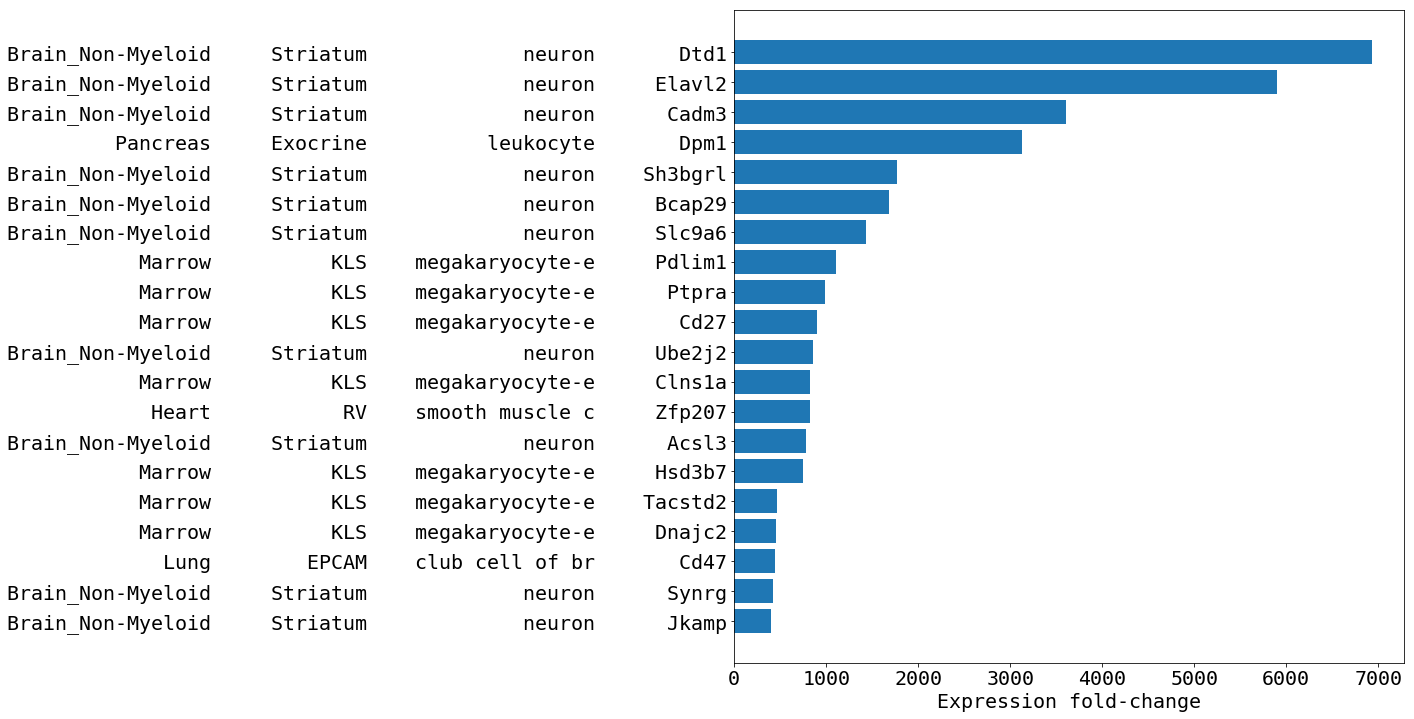

In [189]:
font = {'family' : 'monospace',
        'weight' : 'regular',
        'size'   : 20}

matplotlib.rc('font', **font)

n_plot = 20
fig, ax = plt.subplots(figsize=(12, 12))
ax.barh(np.arange(n_plot), merged_results["dExpression"][:n_plot])
ax.invert_yaxis()
ax.set_xlabel('Expression fold-change')
ax.set_yticks(np.arange(n_plot))
_ = ax.set_yticklabels([
  '{0} {1} {2} {3}'.format(
    row['Tissue'], row['Subtissue'].rjust(12), row['Cell type'][:15].rjust(18), row['Gene'].rjust(10)
  )
  for _, row in merged_results.iloc[:n_plot].iterrows()
])